In [ ]:
# run only if numpy or matploplib packages are not already installed
!pip install -q numpy
!pip install -q matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The Battery Model Object
We model the Battery object in a similar fashion to the model being used in the CityLearn 2022 challenge but in a simpler and more user friendly way.

In [2]:
class Battery:
    def __init__(self, initial_soc: float = 0, initial_capacity: float = 4.3, nominal_power: float = 2.1,
                 time_window: float = 1, max_power_in_curve=None,
                 max_power_out_curve=None, capacity_loss_coefficient: float = 1e-5,
                 power_efficiency_curve=None, efficiency: float = 0.95):
        """
        An Battery object implementation in power and energy units of kW and kWh
        :param initial_soc: Initial SoC (State of Charge) of the battery in units of energy of kWh.
        :param initial_capacity: Initial capacity of the battery in units of energy of kWh.
        :param nominal_power: The battery's nominal in/out power in units of power of kW.
        :param time_window: Time discretization window of the battery in units of hours, used for transforming
        power to energy and vice versa.
        :param max_power_in_curve: A 2D array of (normalized_soc, max_power_in) points,
        i.e. [[0., 0.6, 1.0], [1.0, 0.95, 0.43]], normalized_soc is unit-less in [0, 1].
        :param max_power_out_curve: A 2D array of (normalized_soc, max_power_out) points,
        i.e. [[0., 0.6, 1.0], [1.0, 0.95, 0.43]], normalized_soc is unit-less in [0, 1].
        :param capacity_loss_coefficient: Capacity loss coefficient used for capacity degradation in each soc update.
        :param power_efficiency_curve: A 2D array of (normalized_power, efficiency) points,
        i.e. [[0., 0.2, 0.6, 1.], [0.84, 0.87, 0.95, 0.91]], normalized_power is unit-less in [0, 1].
        :param efficiency: Power efficiency (used only if power_efficiency_curve is None)
        """
        assert 0 < initial_capacity < np.inf, f"The battery's capacity should be a positive finite number, " \
                                              f"instead got {initial_capacity}."
        assert 0 <= initial_soc <= initial_capacity, f"The battery's initial soc should be a positive number " \
                                                     f"bounded by the capacity, instead got {initial_soc}."
        assert 0 < nominal_power < np.inf, f"The battery's nominal power should be a positive finite number, " \
                                           f"instead got {nominal_power}."
        assert 0 < time_window < np.inf, f"The battery's time window should be a positive finite number, " \
                                         f"instead got {time_window}."
        assert 0 <= capacity_loss_coefficient < 1, f"The battery's capacity loss coefficient should be a positive " \
                                                   f"number in the [0, 1) interval, instead " \
                                                   f"got {capacity_loss_coefficient}."
        assert 0 < efficiency <= 1, f"The battery's efficiency should be a positive number in the interval (0, 1], " \
                                    f"instead got {efficiency}."

        self.initial_soc = initial_soc
        self.current_soc = initial_soc
        self.previous_soc = initial_soc
        self.initial_capacity = initial_capacity
        self.capacity = initial_capacity
        self.capacity_loss_coefficient = capacity_loss_coefficient
        self.nominal_power = nominal_power
        self.time_window = time_window
        self.max_power_in_curve = max_power_in_curve
        self.max_power_out_curve = max_power_out_curve
        self.power_efficiency_curve = power_efficiency_curve
        self.efficiency = efficiency
        self.soc_history = [initial_soc]
        self.capacity_history = [initial_capacity]

    @staticmethod
    def sample_curve(curve, x) -> float:
        """
        Given a curve described by a finite number of points, compute the linear interpolation of a given new point.
        :param curve: A 2D array of (x, f(x)) points, i.e. [[0., 0.6, 1.0], [1.0, 0.95, 0.43]].
        :param x: A new x point to find its y = f_{interpolation}(x)
        :return: y
        """
        idx = max(0, np.argmin(np.abs(np.array(curve[0]) - x)) - 1)
        slope = (curve[1][idx+1] - curve[1][idx]) / (curve[0][idx+1] - curve[0][idx])
        bias = curve[1][idx] - slope * curve[0][idx]
        return slope * x + bias

    @property
    def get_max_power_in(self) -> float:
        """
        Computes the battery's maximum power input in units of kW.
        :return: max_power_in
        """
        if self.max_power_in_curve is not None:
            return self.sample_curve(self.max_power_in_curve, self.current_soc / self.capacity) * self.nominal_power
        else:
            return self.nominal_power

    @property
    def get_max_power_out(self) -> float:
        """
        Computes the battery's maximum power output in units of kW.
        :return: max_power_out
        """
        if self.max_power_out_curve is not None:
            return self.sample_curve(self.max_power_out_curve, self.current_soc / self.capacity) * self.nominal_power
        else:
            return self.nominal_power

    @property
    def max_energy_in(self) -> float:
        """
        Computes the battery's maximum energy input.
        :return: max_energy_in = max_power_in * time_window
        """
        return self.get_max_power_in * self.time_window

    @property
    def max_energy_out(self) -> float:
        """
        Computes the battery's maximum energy output.
        :return: max_energy_out = max_power_out * time_window
        """
        return self.get_max_power_out * self.time_window

    def efficiency_per_energy(self, energy) -> float:
        """
        Computes the battery's efficiency for the given energy charge/discharge. This implementation assumes that
        efficiency is symmetric with respect to the energy sign (charge vs discharge).
        :param energy: Input/Output energy in kWh
        :return: efficiency
        """
        avg_power = np.abs(energy) / self.time_window
        return self.get_power_efficiency(avg_power)

    def get_power_efficiency(self, power) -> float:
        """
        Computes the power efficiency of the battery.
        :param power: Input power in kWh.
        :return: efficiency
        """
        if self.power_efficiency_curve is not None:
            return self.sample_curve(self.power_efficiency_curve, power / self.nominal_power)
        else:
            return self.efficiency

    def capacity_degrade(self) -> None:
        """
        Computes a single step energy dependent capacity degradation (symmetric in energy sign).
        :return: None
        """
        self.capacity -= self.capacity_loss_coefficient * abs(self.current_soc - self.previous_soc) * \
                         self.capacity / self.initial_capacity
        self.capacity_history.append(self.capacity)

    def charge(self, energy, efficiency) -> None:
        """
        Charge the battery, update the current soc.
        :param energy: Input/Output energy in kWh
        :param efficiency: The efficiency of operation (energy dependent)
        :return: None
        """
        self.previous_soc = self.current_soc
        self.current_soc = min(self.current_soc + energy * efficiency, self.capacity) if energy >= 0 \
            else max(self.current_soc + energy / efficiency, 0)
        self.soc_history.append(self.current_soc)

    def update_soc(self, action) -> None:
        """
        Updates the battery's SoC (State of Charge) given an action from the agent.
        :param action: The agent's action in [0, 1]
        :return: None
        """
        # compute energy from action
        energy = action * self.capacity

        # verify energy in limiting factors
        energy = min(energy, self.max_energy_in) if energy >= 0 else max(energy, -self.max_energy_out)

        # get current efficiency
        efficiency = self.efficiency_per_energy(energy)

        # charge battery
        self.charge(energy, efficiency)

        # degrade capacity
        self.capacity_degrade()

### An illustration utility function

In [5]:
def plot_results(actions, battery):
    t_max = len(actions)
    fig, axes = plt.subplots(4, 1, sharex='all', figsize=(16, 7))
    axes[0].plot(range(t_max), actions, 'o', label='actions')
    axes[0].set_ylabel('action')
    axes[0].set_ylim([min(-1.1, min(actions)), max(1.1, max(actions))])
    axes[0].legend()
    axes[0].grid()
    axes[1].plot(range(0, t_max + 1), battery.soc_history, '-o', label="soc")
    axes[1].set_ylabel('soc [kWh]')
    axes[1].set_ylim([-0.1, battery.initial_capacity])
    axes[1].legend()
    axes[1].grid()
    axes[2].plot(range(1, t_max+1), np.diff(battery.soc_history), '-x', label="$\delta$soc")
    axes[2].set_ylabel('soc diff [kWh]')
    axes[2].set_ylim([-battery.initial_capacity-0.1, battery.initial_capacity+0.1])
    axes[2].legend()
    axes[2].grid()
    axes[3].plot(range(t_max + 1), battery.capacity_history, '-x', label="capacity")
    axes[3].set_ylabel('capacity [kWh]')
    axes[3].legend()
    axes[3].set_xlabel('time step [h]')
    axes[3].set_xticks(range(t_max + 1))
    axes[3].set_xticklabels([str(t) for t in range(t_max + 1)])
    axes[3].grid()
    plt.show()

### Experiment woth the battery object

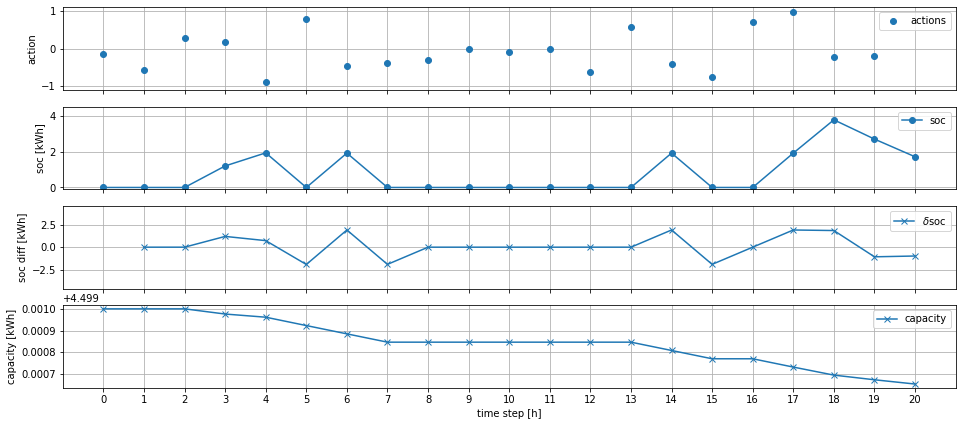

In [6]:
# define the capacity power curve
power_curve = [[0., 0.6, 1.0], [1.0, 0.95, 0.43]]

# define the power efficiency curve
efficiency_curve = [[0., 0.2, 0.6, 1.], [0.84, 0.87, 0.95, 0.91]]

# init a Battery object
battery = Battery(initial_soc=0,
                  initial_capacity=4.5,
                  nominal_power=2.1,
                  time_window=1,
                  max_power_in_curve=power_curve,
                  max_power_out_curve=power_curve,
                  capacity_loss_coefficient=2e-5,
                  power_efficiency_curve=efficiency_curve,
                  efficiency=0.96)

# determine the length of simulation
t_max = 20

# generate a list of random actions (or define it by hand)
actions = 2 * (np.round(np.random.rand(t_max), 2) - 0.5)
# actions = [1, 1, 1, 1, -1, 0.5, 0.2, -0.5, -0.2, 0.9]

# run the actions on the battery
for _, a in enumerate(actions):
    battery.update_soc(a)

# plot the battery behaviour
plot_results(actions, battery)